#  1. 项目背景介绍：
随着人们生活水平的不断提高，肉早已不是奢侈品，因此人们对于肉的关注点往往就会落在肉的品质上。通过计算机视觉的技术，人们能够在肉的生产线上，运输途中，用户饭前这三者中的每一环节都做到对肉的品质的方便高效的识别，既有效避免了劣质肉品流入市场，保证市场良性运转，又有助于提高人们的生活质量。

# 2. 数据集介绍：
本项目所用数据集为：[新鲜和过期红肉数据集](https://aistudio.baidu.com/aistudio/datasetdetail/84831)
数据集中共有图像1896张，其中新鲜（Fresh）和过期（Spoil）红肉各一半。每张像素为1280x720.


## 图片随机展示：

		 这是过期红肉


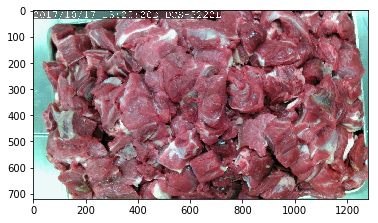

In [2]:
import os
import random
import cv2 as cv
import matplotlib.pyplot as plt

img_list = []
path = 'dataset'
for i in os.listdir(path):
    class_path = os.path.join(path,i)
    for j in os.listdir(class_path):
        img_path = os.path.join(class_path,j)
        img_list.append(img_path)
random.shuffle(img_list)# 打乱图片路径的排序，以实现“随机”效果

img = cv.imread(img_list[0])
img = img[:,:,::-1]  # 得到正常图像
plt.imshow(img)
if 'fresh' in img_list[0]:
    print('\t\t 这是新鲜红肉')
else:
    print('\t\t 这是过期红肉')



# 3. 模型介绍:
本项目用的模型为resnet50.

ResNet网络是参考了VGG19网络，在其基础上进行了修改，并通过短路机制加入了残差单元。

变化主要体现在ResNet直接使用stride=2的卷积做下采样，并且用global average pool层替换了全连接层。ResNet的一个重要设计原则是：当feature map大小降低一半时，feature map的数量增加一倍，这保持了网络层的复杂度。

ResNet相比普通网络每两层间增加了短路机制，这就形成了残差学习。对于18-layer和34-layer的ResNet，其进行的两层间的残差学习，当网络更深时，其进行的是三层间的残差学习，三层卷积核分别是1x1，3x3和1x1，一个值得注意的是隐含层的feature map数量是比较小的，并且是输出feature map数量的1/4。


参考文章：[https://zhuanlan.zhihu.com/p/31852747](https://zhuanlan.zhihu.com/p/31852747)


# 4. 模型训练：


## 解压数据并清除无关文件，方便生成TXT文件

In [3]:
!unzip -oq data/data84831/Meat_Quality_Assessment_Dataset.zip -d dataset
!rm -r dataset/README.txt
!rm -r dataset/license.txt
!tree dataset -d

dataset
├── Fresh
└── Spoiled

2 directories


## 将数据划分为文本

In [5]:
import os
import random
file_path = 'dataset'
data_list = []
if(os.path.exists('dataset/train.txt')):
    os.remove('dataset/train.txt')
if(os.path.exists('dataset/val.txt')):
    os.remove('dataset/val.txt')

value = 0
for i in os.listdir(file_path):
    value += 1
    path = os.path.join(file_path,i)
    if os.path.isdir(path):
        for j in os.listdir(path):
            
            im = os.path.join(path,j) + ' ' + str(value - 2)
            data_list.append(im)
random.shuffle(data_list)
print(data_list[0])  # 打印出打乱后的一张图片路径
data_len = len(data_list)
print(data_len) # 图片大小，与数据集中显示的一致
count = 0
for data in data_list:
    if count <= data_len*0.2:
        with open('val.txt','a') as f1:
            f1.write(data+'\n')
            count += 1
    else:
        with open('train.txt','a') as f2: # 即所谓80%写入了训练集
            f2.write(data+'\n')
            count += 1



dataset/Fresh/test_20171017_133521D.jpg -1
1896


## 定义数据集类

In [8]:
import paddle
import numpy as np
import paddle.vision.transforms as T
from PIL import Image


class MeatDataset(paddle.io.Dataset):
    def __init__(self, mode='train'):
        """
        初始化函数
        """
        self.data = []
        with open(f'{mode}.txt') as f:
            for line in f.readlines():
                info = line.strip().split(' ')
                if len(info) > 0:
                    self.data.append([info[0].strip(), info[1].strip()])
        self.transform = T.Compose([
            T.Resize(size=(224, 224)),
            T.ToTensor(),
            T.Normalize(mean=127.5, std=127.5)])


    def __getitem__(self, index):
        """
        读取图片，对图片进行归一化处理，返回图片和 标签
        """
        image_file, label = self.data[index]  # 获取数据
        img = Image.open(image_file)  # 读取图片
        img = img.convert('RGB')
        img = img.resize((224, 224), Image.ANTIALIAS)  # 图片大小样式归一化
        img = np.array(img).astype('float32')  
        img = img.transpose((2, 0, 1))     
        img = img / 255.0  
        return img, np.array(label, dtype='int64')


    def __len__(self):
        """
        获取样本总数
        """
        return len(self.data)

In [9]:
train_dataset = MeatDataset(mode='train')
val_dataset = MeatDataset(mode='val')
print(len(train_dataset))
print(len(val_dataset))

image, label = train_dataset[0]
print(image.shape, label.shape)

for image, label in train_dataset:
    print(image.shape, label.shape)
    break

4548
1140
(3, 224, 224) ()
(3, 224, 224) ()


## 测试数据集类

In [10]:
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size = 128,
    shuffle = True,
    drop_last = False)

for step, data in enumerate(train_dataloader):
    image, label = data
    print(step, image.shape, label.shape)

0 [128, 3, 224, 224] [128]
1 [128, 3, 224, 224] [128]
2 [128, 3, 224, 224] [128]
3 [128, 3, 224, 224] [128]
4 [128, 3, 224, 224] [128]
5 [128, 3, 224, 224] [128]
6 [128, 3, 224, 224] [128]
7 [128, 3, 224, 224] [128]
8 [128, 3, 224, 224] [128]
9 [128, 3, 224, 224] [128]
10 [128, 3, 224, 224] [128]
11 [128, 3, 224, 224] [128]
12 [128, 3, 224, 224] [128]
13 [128, 3, 224, 224] [128]
14 [128, 3, 224, 224] [128]
15 [128, 3, 224, 224] [128]


## 开始建立模型

In [44]:
from paddle.vision.models import resnet50
from paddle.metric import Accuracy
import paddle

model = resnet50()
paddle.summary(model, (1,3, 224, 224))

model = paddle.Model(model)
optim = paddle.optimizer.Momentum(
    learning_rate=0.001, 
    momentum=0.9, 
    parameters=model.parameters(), 
    weight_decay=0.001)

model.prepare(
    optimizer=optim,
    loss=paddle.nn.CrossEntropyLoss(),
    metrics=Accuracy()
    )



## 训练模型

In [49]:
model.fit(
    train_dataset,
    epochs=10,
    batch_size=128,
    verbose=1
    )

# 5. 模型评估

In [50]:
model.evaluate(val_dataset, batch_size=128, verbose=1)

# 6. 总结与升华：

亮点： 利用Resnet模型成功实现了新鲜与过期红肉的鉴别，准确率保持在较高水平；

不足： 数据集不大，有部分功能没来得及实现；

改进： API文档值得反复咀嚼。

# 7. 个人总结：
本科大学生，对人工智能很感兴趣，方向是计算机视觉。

个人主页：[https://aistudio.baidu.com/aistudio/usercenter](https://aistudio.baidu.com/aistudio/usercenter)

# 提交链接：
aistudio链接

GitHub链接

gitee链接

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 